In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/10dataset-text-document-classification/space/space_73.txt
/kaggle/input/10dataset-text-document-classification/space/space_33.txt
/kaggle/input/10dataset-text-document-classification/space/space_5.txt
/kaggle/input/10dataset-text-document-classification/space/space_8.txt
/kaggle/input/10dataset-text-document-classification/space/space_66.txt
/kaggle/input/10dataset-text-document-classification/space/space_87.txt
/kaggle/input/10dataset-text-document-classification/space/space_17.txt
/kaggle/input/10dataset-text-document-classification/space/space_21.txt
/kaggle/input/10dataset-text-document-classification/space/space_39.txt
/kaggle/input/10dataset-text-document-classification/space/space_42.txt
/kaggle/input/10dataset-text-document-classification/space/space_34.txt
/kaggle/input/10dataset-text-document-classification/space/space_54.txt
/kaggle/input/10dataset-text-document-classification/space/space_53.txt
/kaggle/input/10dataset-text-document-classification/space/space_6

In [2]:
! head /kaggle/input/10dataset-text-document-classification/business/business_80.txt


Continental 'may run out of cash'

Shares in Continental Airlines have tumbled after the firm warned it could run out of cash.

In a filing to US regulators the airline warned of "inadequate liquidity" if it fails to reduce wage costs by $500m by the end of February. Continental also said that, if it did not make any cuts, it expects to lose "hundreds of millions of dollars" in 2005 in current market conditions. Failure to make cutbacks may also push it to reduce its fleet, the group said. Shares in the fifth biggest US carrier had fallen 6.87% on the news to $10.44 by 1830 GMT. "Without the reduction in wage and benefit costs and a reasonable prospect of future profitability, we believe that our ability to raise additional money through financings would be uncertain," Continental said in its filing to the US Securities and Exchange Commission (SEC).

Airlines have faced tough conditions in recent years, amid terrorism fears since the 11 September World Trade Centre attack in 2001. But

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
## we will be removing all the stopwords from all the text file and stemming the text.

from nltk.corpus import stopwords
import nltk

stop_words = stopwords.words('english')
prt = nltk.stem.PorterStemmer()

def preprocess(document_path):
    
    with open(document_path, 'r') as file:
        document = file.read()
        tokens = document.split(" ")
#     tokens = nltk.word_tokenize(document)

        tokens_pun_lower = [i.lower() for i in tokens if i.isalnum()]

        tokens_stop = [i for i in tokens_pun_lower if i not in stop_words]

    #terms = [prt.stem(i) for i in tokens_stop]
    
    return " ".join(tokens_stop)
import os
Data = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        
        doc_class = filename.split('_')[0].lower()
        doc_titles = filename
        documents = preprocess(os.path.join(dirname, filename))
        
        Data.append([doc_titles, documents, doc_class])

df = pd.DataFrame (Data, columns = ['Title', 'Document', 'Class'])

In [5]:
df.head()


,Title,Document,Class
0,space_73.txt,series linked messages periodically posted att...,space
1,space_33.txt,article according iau circular comet may tempo...,space
2,space_5.txt,anyone know size cold gas roll control thruste...,space
3,space_8.txt,one ssrbs recovered space shuttle launch found...,space
4,space_66.txt,recent observations taken hubble space faint o...,space


In [6]:
df.to_csv("documents_raw.csv", index=False)

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
token = tokenizer.encode_plus(
    df['Document'].iloc[0], 
    max_length=256, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True,
    return_tensors='tf'
)

In [9]:
X_input_ids = np.zeros((len(df), 256))
X_attn_masks = np.zeros((len(df), 256))

In [10]:
def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['Document'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [11]:
X_input_ids, X_attn_masks = generate_training_data(df, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

In [12]:
labels = np.zeros((len(df), 10))
labels.shape

(1000, 10)

In [13]:
df['Class'] = pd.factorize(df['Class'])[0]
df.head()

,Title,Document,Class
0,space_73.txt,series linked messages periodically posted att...,0
1,space_33.txt,article according iau circular comet may tempo...,0
2,space_5.txt,anyone know size cold gas roll control thruste...,0
3,space_8.txt,one ssrbs recovered space shuttle launch found...,0
4,space_66.txt,recent observations taken hubble space faint o...,0


In [14]:
df.to_csv("documents.csv", index=False)

In [15]:
labels[np.arange(len(df)), df['Class'].values.astype(int)] = 1

In [16]:
# creating a data pipeline using tensorflow dataset utility, creates batches of data for easy loading...
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # one sample data
     

<_TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(10,), dtype=tf.float64, name=None))>

In [17]:
def ModelDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [18]:
dataset = dataset.map(ModelDatasetMapFunction)

In [19]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(10,), dtype=tf.float64, name=None))>

In [20]:
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True) # batch size, drop any left out tensor

In [21]:
p = 0.8
train_size = int((len(df)//16)*p) # for each 16 batch of data we will have len(df)//16 samples, take 80% of that for train

In [22]:
train_size

49

In [23]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)


In [24]:
from transformers import TFBertModel

In [25]:
model = TFBertModel.from_pretrained('bert-base-cased')

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [26]:
from tensorflow.keras import regularizers
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')
bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer', kernel_regularizer=regularizers.l2(0.01))(bert_embds)
drop_out = tf.keras.layers.Dropout(0.2, name="dropout")(intermediate_layer)
output_layer = tf.keras.layers.Dense(10, activation='softmax', name='output_layer', kernel_regularizer=regularizers.l2(0.01))(drop_out) # softmax -> calcs probs of classes

model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 256, 7                                       

In [27]:
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5, decay_rate=1e-6, decay_steps=10000)

optim = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)

loss_func = tf.keras.losses.CategoricalCrossentropy()

acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
precision = tf.keras.metrics.Precision(name='precision')
recall = tf.keras.metrics.Recall(name='recall')

model.compile(optimizer=optim, loss=loss_func, metrics=[acc, precision, recall])

In [28]:
hist =model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)

Epoch 1/5
49/49 [==============================] - 69s 572ms/step - loss: 8.5685 - accuracy: 0.1888 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 8.1770 - val_accuracy: 0.4856 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
49/49 [==============================] - 26s 530ms/step - loss: 7.6707 - accuracy: 0.6518 - precision: 0.9739 - recall: 0.1429 - val_loss: 7.0785 - val_accuracy: 0.9087 - val_precision: 0.9888 - val_recall: 0.4231
Epoch 3/5
49/49 [==============================] - 26s 528ms/step - loss: 6.8458 - accuracy: 0.9056 - precision: 0.9761 - recall: 0.6760 - val_loss: 6.5457 - val_accuracy: 0.9663 - val_precision: 0.9947 - val_recall: 0.9087
Epoch 4/5
49/49 [==============================] - 26s 530ms/step - loss: 6.5121 - accuracy: 0.9643 - precision: 0.9848 - recall: 0.9120 - val_loss: 6.3405 - val_accuracy: 0.9952 - val_precision: 0.9951 - val_recall: 0.9808
Epoch 5/5
49/49 [==============================] - 26s 527ms/step - loss: 6.3532 - accur

In [29]:
model.save("textclassification.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
model.evaluate(val_dataset)

13/13 [==============================] - 2s 157ms/step - loss: 6.2416 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000


[6.241580486297607, 1.0, 1.0, 1.0]

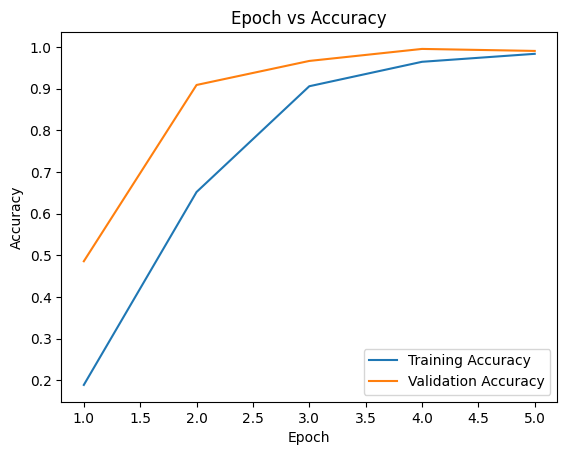

13/13 [==============================] - 2s 157ms/step - loss: 6.2670 - accuracy: 0.9856 - precision: 0.9903 - recall: 0.9808




loss is :  6.266965866088867
accuracy is:  99%
recall is:  98%
Precision is :  99%


In [31]:
import matplotlib.pyplot as plt
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

# Plot the epoch vs accuracy graph
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
loss,accuracy,precision,recall=model.evaluate(val_dataset)
print()
print()
print()
print()
print("loss is : ", loss)

print("accuracy is: ", str(round(accuracy*100))+ "%")
print("recall is: ", str(round(recall*100)) + "%")
print("Precision is : ", str(round(precision*100)) + "%")

In [32]:
model.save('model')

In [33]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=256, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data, classes=['business', 'Entertainment', 'food', 'Graphichs', 'historical','medical','politcis', 'space','sport','technology']):
    probs = model.predict(processed_data)[0]
    return np.argmax(probs)

In [34]:
dict1 = {0:"Space", 1:"Politics",2:"Sport",3:"technology",4:"historical", 5:"Medical", 6:"Graphics",7:"Entertrainment",8:"Food",9:"business"}

In [35]:
text = """Bank voted 8-1 for no rate change

The decision to keep interest rates on hold at 4.75% earlier this month was passed 8-1 by the Bank of England's rate-setting body, minutes have shown.

One member of the Bank's Monetary Policy Committee (MPC) - Paul Tucker - voted to raise rates to 5%. The news surprised some analysts who had expected the latest minutes to show another unanimous decision. Worries over growth rates and consumer spending were behind the decision to freeze rates, the minutes showed. The Bank's latest inflation report, released last week, had noted that the main reason inflation might fall was weaker consumer spending.

However, MPC member Paul Tucker voted for a quarter point rise in interest rates to 5%. He argued that economic growth was picking up, and that the equity, credit and housing markets had been stronger than expected.

The Bank's minutes said that risks to the inflation forecast were "sufficiently to the downside" to keep rates on hold at its latest meeting. However, the minutes added: "Some members noted that an increase might be warranted in due course if the economy evolved in line with the central projection". Ross Walker, UK economist at Royal Bank of Scotland, said he was surprised that a dissenting vote had been made so soon. He said the minutes appeared to be "trying to get the market to focus on the possibility of a rise in rates". "If the economy pans out as they expect then they are probably going to have to hike rates." However, he added, any rate increase is not likely to happen until later this year, with MPC members likely to look for a more sustainable pick up in consumer spending before acting.
"""

In [36]:
input_text = text
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(model, processed_data=processed_data)
print(f"Predicted model: {result}")
     

1/1 [==============================] - 3s 3s/step
Predicted model: 9


In [37]:
output = dict1[result]

In [38]:
result

9

In [39]:
print(output)

business
